# Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import imsave
import glob
import time
import csv


# Sklearn imports
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage.measurements import label

#### Tuning parameters

In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()
hog_channel = 'ALL'


test_dir = "test_images\\"
img_test = glob.glob(test_dir + "*.jpg")

# Training Data

#### Data from gti database

Training image shape:  (64, 64, 3)


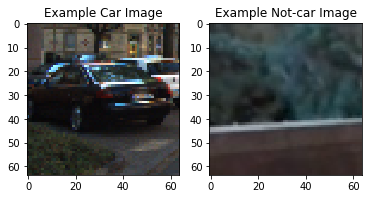

In [3]:
gti_database = "pics\\*\\*\\*.png"
images = glob.glob(gti_database)
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])  # Loads images between 0 and 1
#car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])  # Loads images between 0 and 255

print("Training image shape: ", car_image.shape)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### Data from udacity

In [4]:
# Extracts 70,000 images of cars

"""
jpeg_dir = 'object-detection-crowdai\\'

with open('object-detection-crowdai\\labels.csv') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    next(csvreader, None)  # Skip header row
    for index, row in enumerate(csvreader):
        if row[5] == 'Pedestrian':
            continue
        img = mpimg.imread(jpeg_dir+row[4])
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        img = img[y1:y2, x1:x2]
        try:
            img = cv2.resize(img, (64,64))
        except Exception:
            continue
        imsave("udacity_cars\\car_{}.png".format(index), img)
        
skip = 20
count = 0
images = glob.glob("udacity_cars\\*.png")
for image in images:
    count += 1
    if count == skip:
        cars.append(image)
        count = 0
    """


'\njpeg_dir = \'object-detection-crowdai\\\'\n\nwith open(\'object-detection-crowdai\\labels.csv\') as csvfile:\n    csvreader = csv.reader(csvfile, delimiter=\',\')\n    next(csvreader, None)  # Skip header row\n    for index, row in enumerate(csvreader):\n        if row[5] == \'Pedestrian\':\n            continue\n        img = mpimg.imread(jpeg_dir+row[4])\n        x1 = int(row[0])\n        y1 = int(row[1])\n        x2 = int(row[2])\n        y2 = int(row[3])\n        img = img[y1:y2, x1:x2]\n        try:\n            img = cv2.resize(img, (64,64))\n        except Exception:\n            continue\n        imsave("udacity_cars\\car_{}.png".format(index), img)\n        \nskip = 20\ncount = 0\nimages = glob.glob("udacity_cars\\*.png")\nfor image in images:\n    count += 1\n    if count == skip:\n        cars.append(image)\n        count = 0\n    '

# Feature Extraction functions

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def convert_color(img, conv=color_space):
    if conv != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: return img 


def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            img_features.append(hist_features)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            img_features.append(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features

### ML Training

In [6]:
car_features = extract_features(cars, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

C:\Users\DavidCrompton\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [7]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [8]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state, shuffle=True)

In [9]:
# Define models
svr_clf = SVC(C=10, kernel='rbf')

In [10]:
t=time.time()
svr_clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train svr...')
# Check the score of the svr
print('Test Accuracy of svr = ', round(svr_clf.score(X_test, y_test), 4))

360.88 Seconds to train svr...
Test Accuracy of svr =  0.9961


Fitting 3 folds for each of 4 candidates, totalling 12 fits

280.79 Seconds to train svr...

Test Accuracy of svr =  0.9918

Fitting 3 folds for each of 192 candidates, totalling 576 fits

5000.4 Seconds to train rfc...

Test Accuracy of rfc =  0.9829

0.61 Seconds to train gnb...

Test Accuracy of gnb =  0.9556

### Window Search Functions

In [11]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy))) 
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    img_features = []

    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
        
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    return np.concatenate(img_features)

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [12]:
def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: return np.copy(img) 


def find_cars(img, clf, scaler, orient=orient, 
              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size,
              hist_bins=hist_bins, scale=1, y_start_stop=[None, None]):
    
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    ystart = y_start_stop[0]
    ystop = y_start_stop[1]
    draw_img = np.copy(img)

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2 
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog_features = []
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_features = []
            hog_features.extend(hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
            hog_features.extend(hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()) 
            hog_features.extend(hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            img_features = []
            img_features.append(spatial_features)
            img_features.append(hist_features)
            img_features.append(hog_features)
            features = np.concatenate(img_features)
            
            test_features = scaler.transform(np.array(features).reshape(1, -1))    

            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [13]:
def find_bbox(img, clf, scaler, orient=orient, 
              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size,
              hist_bins=hist_bins, scale=1, y_start_stop=[None, None]):
    
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    ystart = y_start_stop[0]
    ystop = y_start_stop[1]
    draw_img = np.copy(img)

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2 
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog_features = []
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxs = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_features = []
            hog_features.extend(hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
            hog_features.extend(hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()) 
            hog_features.extend(hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            img_features = []
            img_features.append(spatial_features)
            img_features.append(hist_features)
            img_features.append(hog_features)
            features = np.concatenate(img_features)
            
            test_features = scaler.transform(np.array(features).reshape(1, -1))    

            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                bboxs.append([(xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)])
                
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bboxs

### Image pipeline

In [14]:
class box_history():
    def __init__(self, threshold=0):
        self.threshold = threshold  # Threshold to ignore detections
        
    def add_heat(self, heatmap, bbox_list):
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        return heatmap

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        return heatmap
    
    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            nonzero = (labels[0] == car_number).nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,1), 6)
        return img
    
    def draw_bboxes(self, img, boxes):
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heatmap = self.add_heat(heat, boxes)
        heatmap = self.apply_threshold(heatmap, self.threshold)
        labels = label(heatmap)
        draw_img = self.draw_labeled_bboxes(img, labels)
        return draw_img

C:\Users\DavidCrompton\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


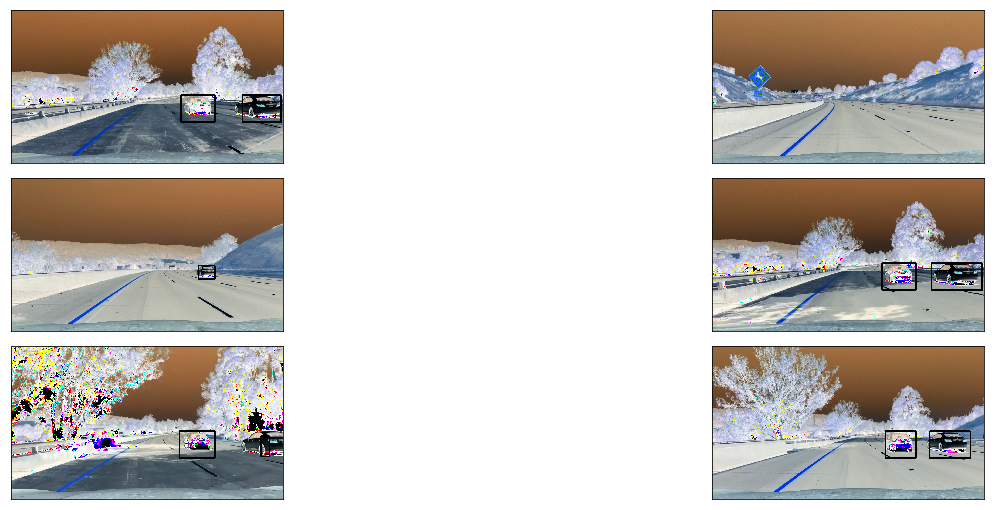

In [21]:
def pipeline(img):
    img = img.astype(np.float32)/255  # Test images are jpegs so rescale to be between 0-1
    
    total_bboxes = []
    total_bboxes.extend(find_bbox(img, clf=svr_clf, scaler=X_scaler, scale=0.8, y_start_stop=[450, 720]))
    total_bboxes.extend(find_bbox(img, clf=svr_clf, scaler=X_scaler, scale=1.5, y_start_stop=[450, 680]))
    total_bboxes.extend(find_bbox(img, clf=svr_clf, scaler=X_scaler, scale=2, y_start_stop=[400, 600]))

    #box.add_bboxes(total_bboxes)
    draw_img = box.draw_bboxes(img, total_bboxes)
    draw_img = draw_img.astype(np.float32)*255
    
    return draw_img


box = box_history(threshold=1) 

test_imgs = []
for img in img_test:
    img = mpimg.imread(img)
    img = pipeline(img)
    test_imgs.append(img)

idx = range(len(img_test))
fig, axes = plt.subplots(3, 2, figsize=(24,9),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(test_imgs[ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

### Test on video file

In [22]:
box = box_history(threshold=1)  # The car needs to be seen in all the frames to count as a detection

import importlib
import imageio
imageio.plugins.ffmpeg.download()
import moviepy.editor as me
from IPython.display import HTML

In [24]:
clip1_output = "output19.mp4"


clip1 = me.VideoFileClip("project_video.mp4")
clip1 = clip1.fl_image(pipeline)
%time clip1.write_videofile(clip1_output, audio=False)

[MoviePy] >>>> Building video output19.mp4
[MoviePy] Writing video output19.mp4


100%|██████████████████████████████████████████████████████████████████████████▉| 1260/1261 [23:33:35<01:07, 67.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output19.mp4 

Wall time: 23h 33min 36s


# Plots and other things

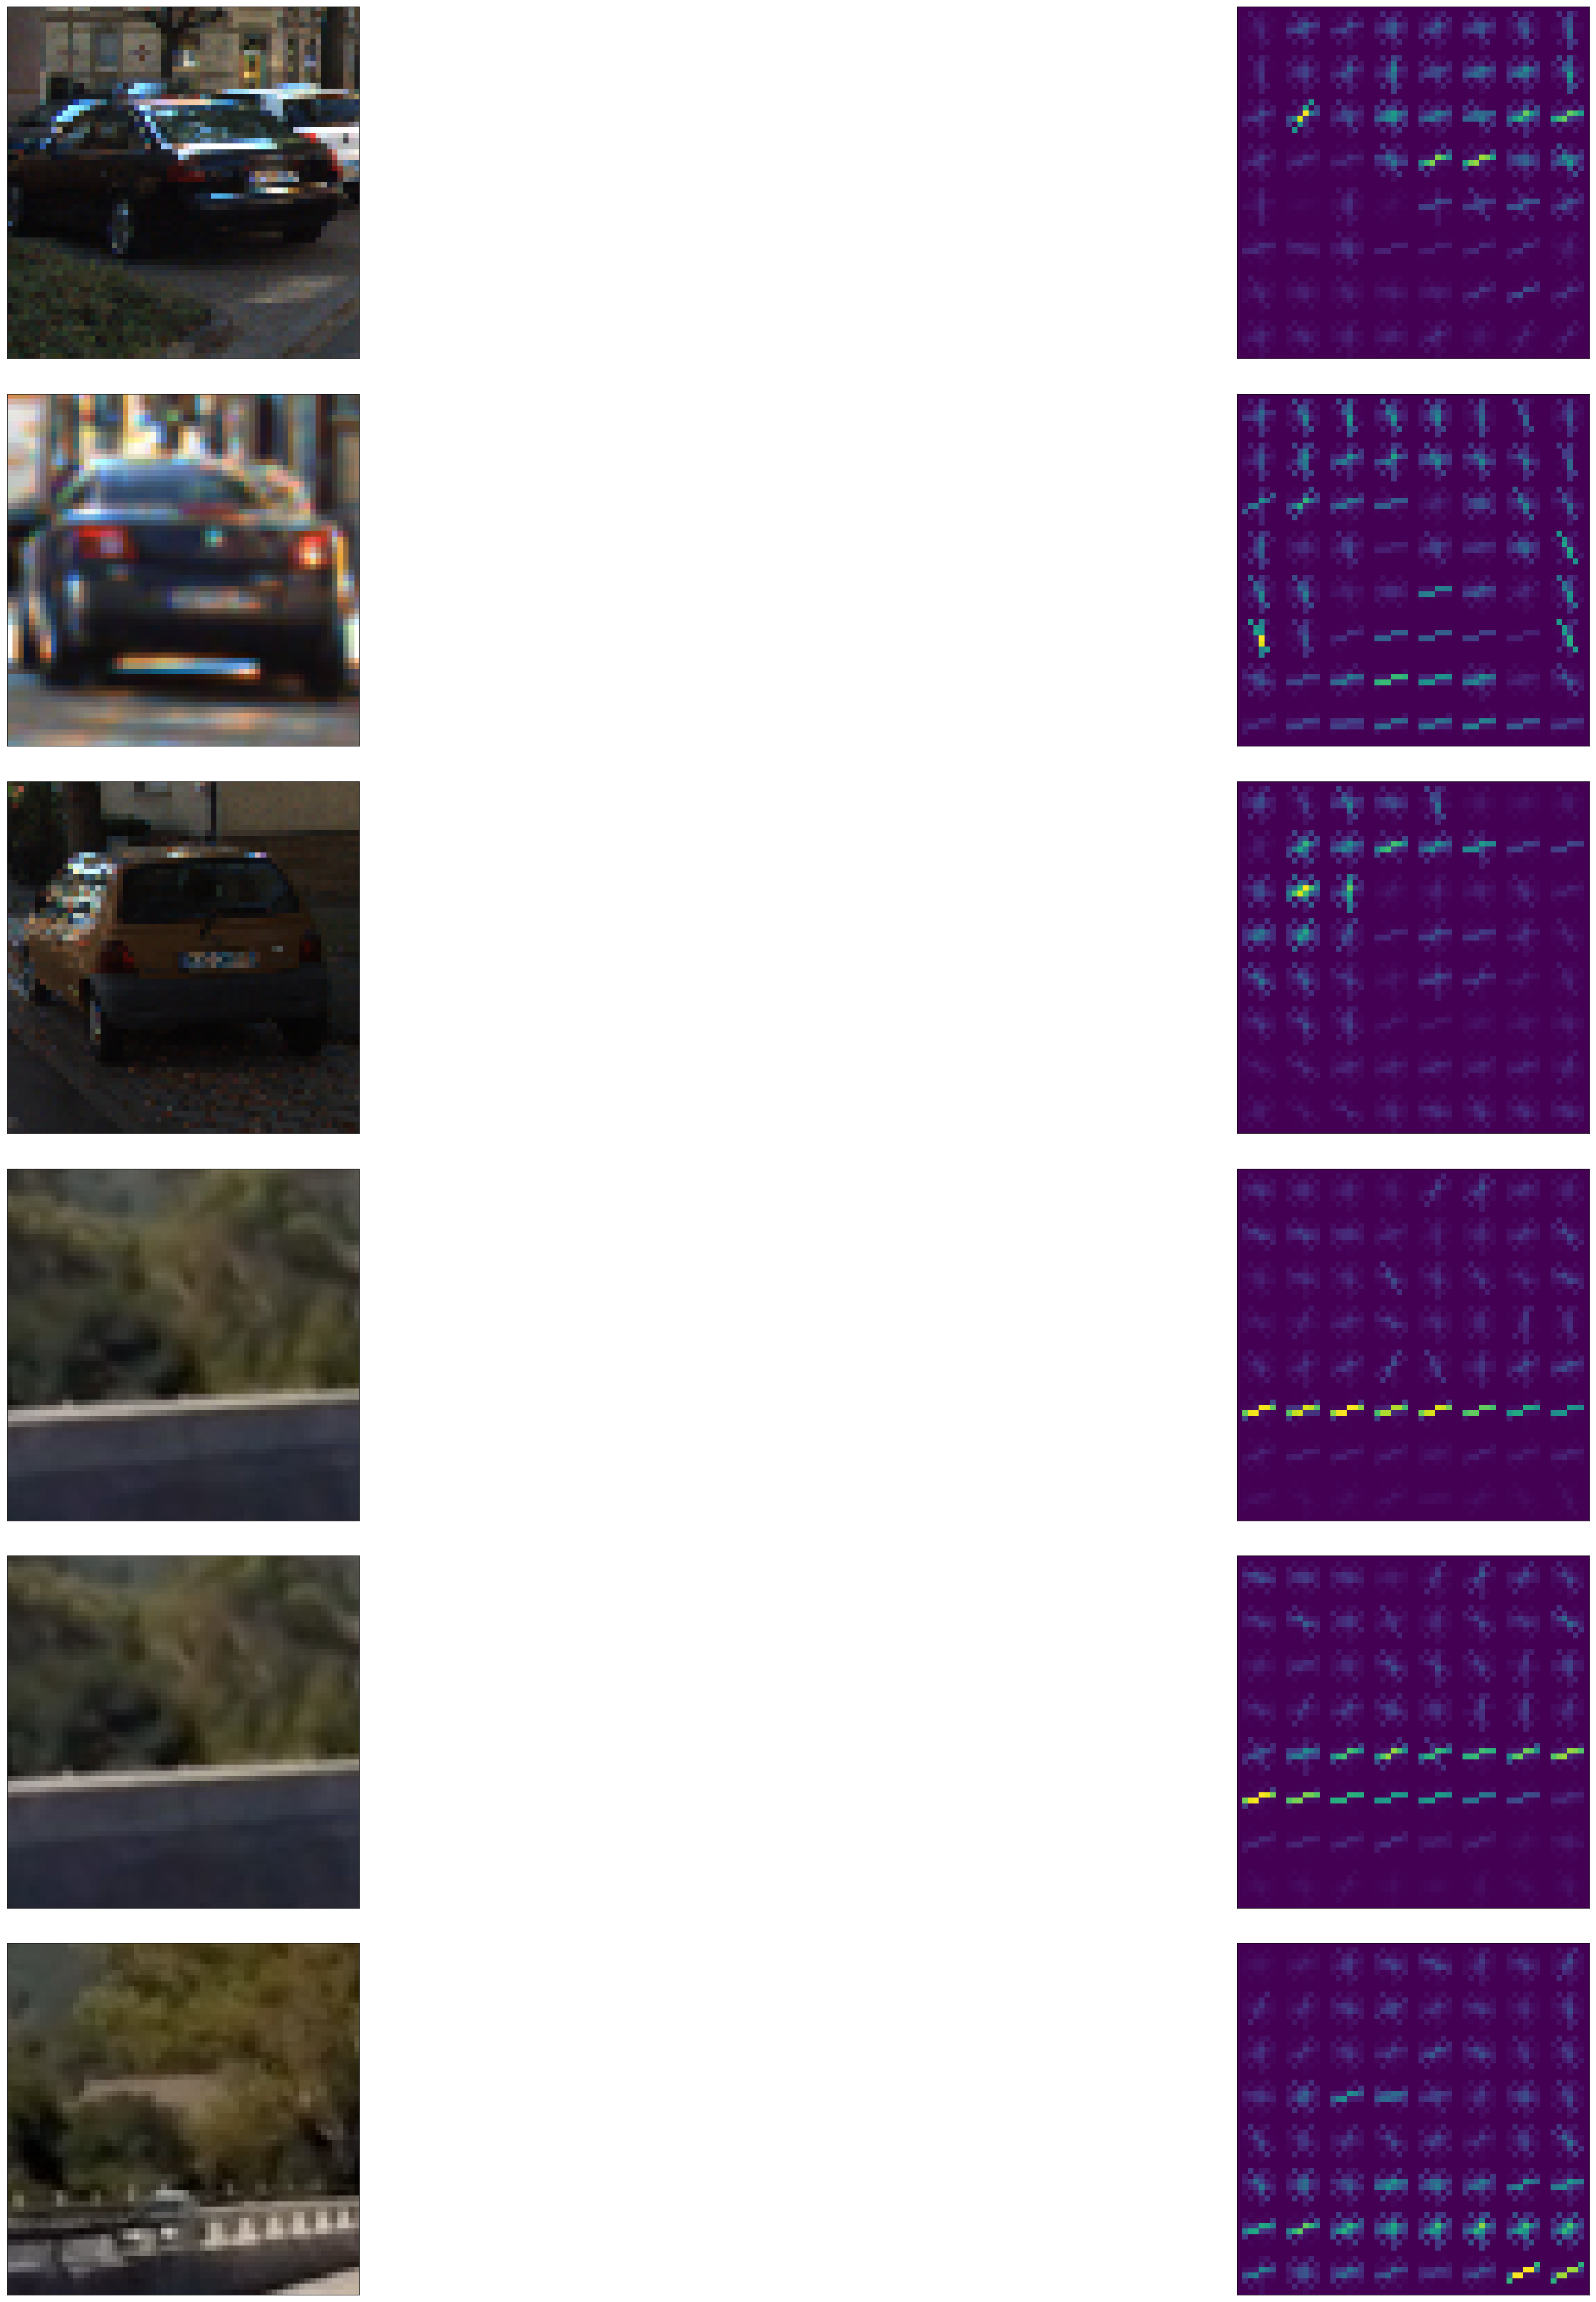

In [33]:

cars_test = cars[car_ind:car_ind+3]
notcars_test = notcars[notcar_ind:notcar_ind+3]

images = cars_test + notcars_test


test_imgs = []
for img in images:
    img = mpimg.imread(img)
    img_2 = convert_color(img, 'YCrCb')
    features, hog_image = get_hog_features(img_2[:,:,0], 
                                    orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    test_imgs.append(img)
    test_imgs.append(hog_image)

idx = range(len(images)*2)
fig, axes = plt.subplots(6, 2, figsize=(64,64),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(test_imgs[ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

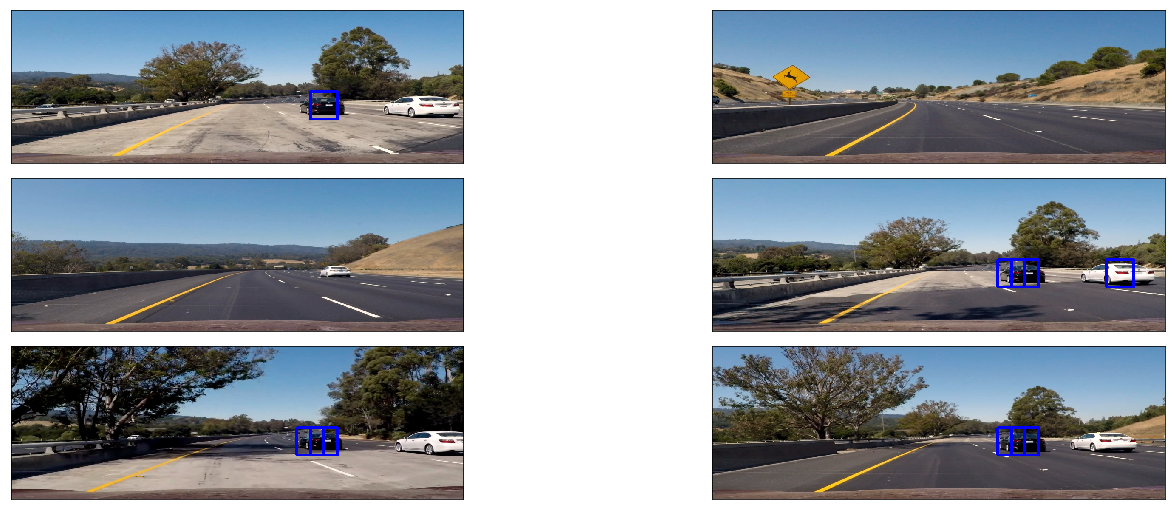

In [45]:
test_imgs = []
for img in img_test:
    img = mpimg.imread(img)
    img = img.astype(np.float32)/255  # Test images are jpegs so rescale to be between 0-1
    img = cv2.resize(img, (int(img.shape[1]/1.2), int(img.shape[0]/2)))
    windows = slide_window(img)
    detections = search_windows(img, windows, svr_clf, X_scaler)

    detections_img = draw_boxes(img, detections, color=(0, 0, 1), thick=6)    
    test_imgs.append(detections_img)

idx = range(len(img_test))
fig, axes = plt.subplots(3, 2, figsize=(24,9),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(test_imgs[ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

In [43]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy))) 
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    img_features = []

    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
        
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    return np.concatenate(img_features)

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

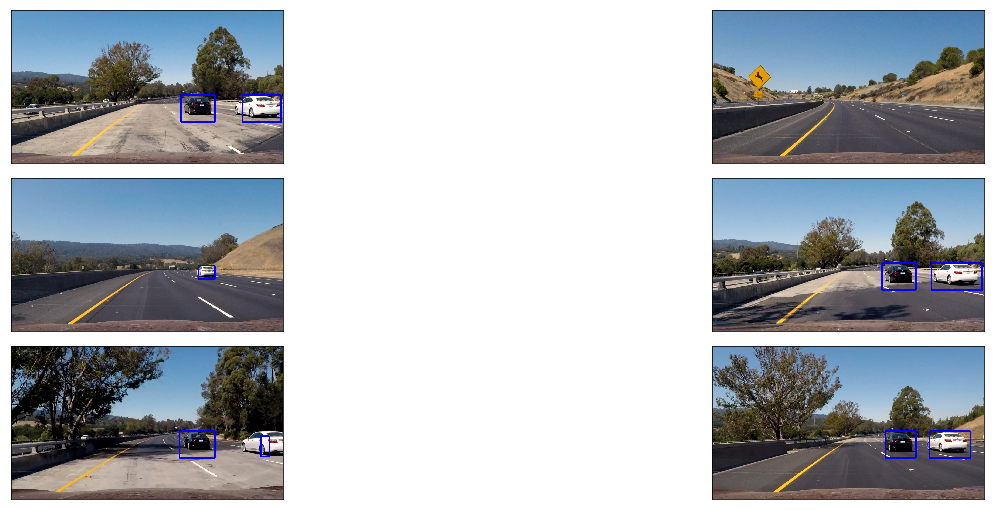

In [47]:
def pipeline(img):
    img = img.astype(np.float32)/255  # Test images are jpegs so rescale to be between 0-1
    
    total_bboxes = []
    total_bboxes.extend(find_bbox(img, clf=svr_clf, scaler=X_scaler, scale=0.8, y_start_stop=[400,720]))
    total_bboxes.extend(find_bbox(img, clf=svr_clf, scaler=X_scaler, scale=1.5, y_start_stop=[400,720]))
    total_bboxes.extend(find_bbox(img, clf=svr_clf, scaler=X_scaler, scale=2, y_start_stop=[400, 720]))

    #box.add_bboxes(total_bboxes)
    draw_img = box.draw_bboxes(img, total_bboxes)
    #draw_img = draw_img.astype(np.float32)*255
    
    return draw_img


box = box_history(threshold=1) 

test_imgs = []
for img in img_test:
    img = mpimg.imread(img)
    img = pipeline(img)
    test_imgs.append(img)

idx = range(len(img_test))
fig, axes = plt.subplots(3, 2, figsize=(24,9),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(test_imgs[ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

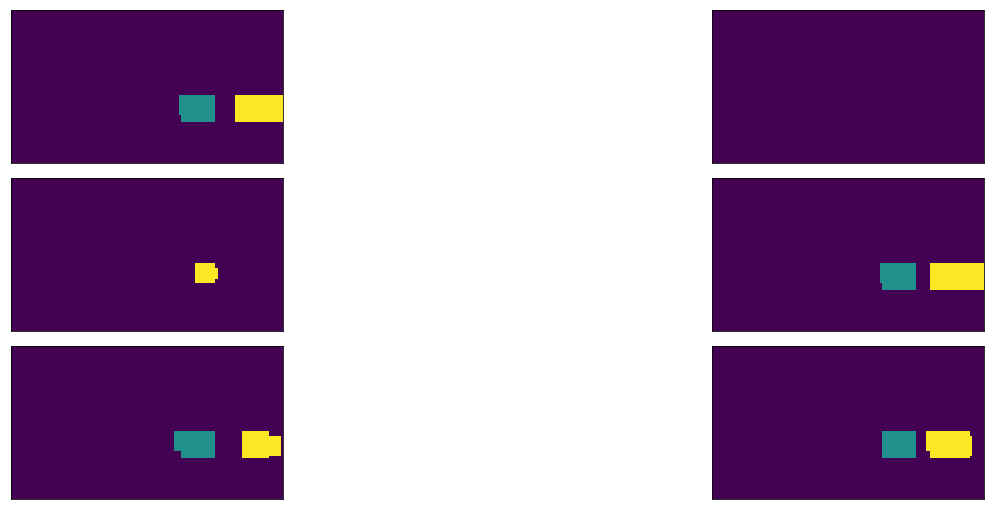

In [52]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def pipeline(img):
    img = img.astype(np.float32)/255  # Test images are jpegs so rescale to be between 0-1
    
    total_bboxes = []
    total_bboxes.extend(find_bbox(img, clf=svr_clf, scaler=X_scaler, scale=0.8, y_start_stop=[400,720]))
    total_bboxes.extend(find_bbox(img, clf=svr_clf, scaler=X_scaler, scale=1.5, y_start_stop=[400,720]))
    total_bboxes.extend(find_bbox(img, clf=svr_clf, scaler=X_scaler, scale=2, y_start_stop=[400, 720]))
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, total_bboxes)
    
    return heatmap


box = box_history(threshold=1) 

test_imgs = []
for img in img_test:
    img = mpimg.imread(img)
    heatmap = pipeline(img)
    labels = label(heatmap)
    test_imgs.append(labels[0])

idx = range(len(img_test))
fig, axes = plt.subplots(3, 2, figsize=(24,9),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(test_imgs[ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)